In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from astropy.constants import c
import astropy.units as u
from scipy.ndimage import gaussian_filter1d
# import the main class
from funcs.auroralring import AuroralRing

from scipy.optimize import curve_fit
import numpy as np

In [25]:

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 90 * np.pi/180


# rotation period in days
P_rot = 2.845 / 24.
omega = 2 * np.pi / P_rot


# stellar radius in solar radii
R_star = (1.07 * u.R_jup).to(u.R_sun).value

vbins = np.linspace(-80, 80, 100)

delta_alpha = 0.1

phi = np.linspace(0, 2*np.pi, 100)

vmax = omega * R_star * 695700. / 86400. # km/s

print(vmax)


def model(vbins, imag, phimax, dphi, alpha_0, ampl, broaden=10, N=3, foreshortening=True): 

    # inclination of magnetic axis in radians relative to rotation axis
    i_mag = imag * np.pi / 180

    # upper latitude of ring around magnetic axis in radians
    PHI_max = phimax * np.pi / 180

    # lower latitude of ring around magnetic axis in radians
    PHI_min = (phimax - dphi) * np.pi / 180

    # width of ring around magnetic axis in radians
    width = PHI_max - PHI_min

    # mid latitude of ring around magnetic axis in radians
    mid_lat = (PHI_max + PHI_min) / 2


    # define the auroral ring
    ring = AuroralRing(i_rot=i_rot, i_mag=i_mag, latitude=mid_lat,
                        width=width, Rstar=R_star, P_rot=P_rot, N=60, 
                    v_bins=vbins, omega=omega, vmax=vmax, phi=phi, gridsize=int(1e3))

    stop = alpha_0 + delta_alpha
    alphas = np.linspace(alpha_0*2*np.pi, stop*2*np.pi, N)

    # wav = ring.v_mids / 2.9979246e5 * 6562.8 + 6562.8
    ddv = ring.v_mids[1] - ring.v_mids[0]

    spectra = [ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=foreshortening) for alpha in alphas]

    specs = []
    for spectrum in spectra:
        # fold each spectrum with a gaussian of width 20 km/s
        dv = broaden * u.km / u.s  / ddv
        
        spectrum = gaussian_filter1d(spectrum, dv.value)
        specs.append(spectrum)
        # plt.plot(wav, spectrum)

    # sum and normalize the spectra
    maxval = np.max(np.sum(specs, axis=0))

    if maxval == 0:
        return np.ones_like(specs[0]) * ampl
    else:
        return np.sum(specs, axis=0) / maxval * ampl + 1

df = pd.read_csv('data/lsr_norm_spectra_median.csv', index_col=0, header=[0,1])


# # plot the sphere with the auroral ring
# fig, ax = ring.plot_setup_sphere()
# ring.get_flux_numerically(alpha=alpha)
# ring.plot_sphere_with_auroral_ring(ax, alpha=alpha, sphere_alpha=0.01, ring_alpha=1.)
# ring.plot_layout_sphere(ax, view='observer left')
index = "(0.4, 0.5]"
x, y, std = df[index].index.values, df[index]["median"].values, df[index]["std"].values
x,y, std
diffx = np.diff(x)
vbins = np.linspace(x[0]-diffx[0]/2, x[-1]+diffx[-1]/2, len(x)+1)

print(vbins)
# convert vbins to km/s
vbins = ((vbins - 6562.8) / 6562.8 * c).to(u.km/u.s).value

vbins

46.92846200542324
[6552.8105111  6552.8393725  6552.8682339  ... 6582.73978481 6582.76864622
 6582.79750762]


array([-456.32556701, -455.00716166, -453.68875631, ...,  910.86077612,
        912.17918146,  913.49758681])

In [ ]:
# make a mcmc setup with emcee
import emcee


def log_likelihood(theta, vbins, y, yerr):
    imag, phimax, dphi, alpha_0, ampl, broaden = theta
    model_ = model(vbins, imag, phimax, dphi, alpha_0, ampl, broaden)
    return  -0.5 * np.sum((y - model_) ** 2 / yerr ** 2)
 
def log_prior(theta):
    imag, phimax, dphi, alpha_0, ampl, broaden = theta
    if 0 < imag < 90 and 0 < phimax < 90 and 0 < dphi < phimax and 0 < alpha_0 < 1 and 0 < ampl < 1e9 and 5 < broaden < 25:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

initial = [30, 30, 10, 0.2, 0.1, 10]
nwalkers = 32
ndim = len(initial)
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(vbins, y, std))

sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:51<00:00, 45.03it/s]


State([[4.13316902e+00 3.04974268e+01 1.16300025e+01 2.26200038e-01
  1.46866899e+00 1.67133263e+01]
 [8.24663113e+00 2.27643059e+01 1.70266644e+00 2.89569214e-01
  1.48632655e+00 1.55356377e+01]
 [4.25514612e-01 2.94242640e+01 2.28694684e+01 2.77428353e-01
  1.44714044e+00 1.50635282e+01]
 [8.89718750e+00 3.60302740e+01 3.09337025e+01 3.47333371e-01
  1.47584341e+00 1.61225267e+01]
 [1.07114680e+01 3.60116428e+01 2.40435564e+01 3.72047305e-01
  1.55258160e+00 1.65491996e+01]
 [1.30025261e+01 5.44426996e+01 5.05899771e+01 3.35824832e-02
  1.52225530e+00 1.61155256e+01]
 [6.60751461e+00 3.67622145e+01 1.92465706e+01 2.82948012e-01
  1.49271946e+00 1.68402075e+01]
 [1.55848017e+01 4.34262475e+01 4.07310689e+01 4.11043680e-01
  1.54466130e+00 1.67556540e+01]
 [2.41505211e+01 2.37390841e+01 1.49217662e+01 4.24840379e-01
  1.45543458e+00 1.60000382e+01]
 [7.13762105e+00 3.92875413e+01 3.29448711e+01 1.82298728e-01
  1.49677308e+00 1.71573514e+01]
 [1.42593061e+01 5.13493496e+01 4.37128193e+

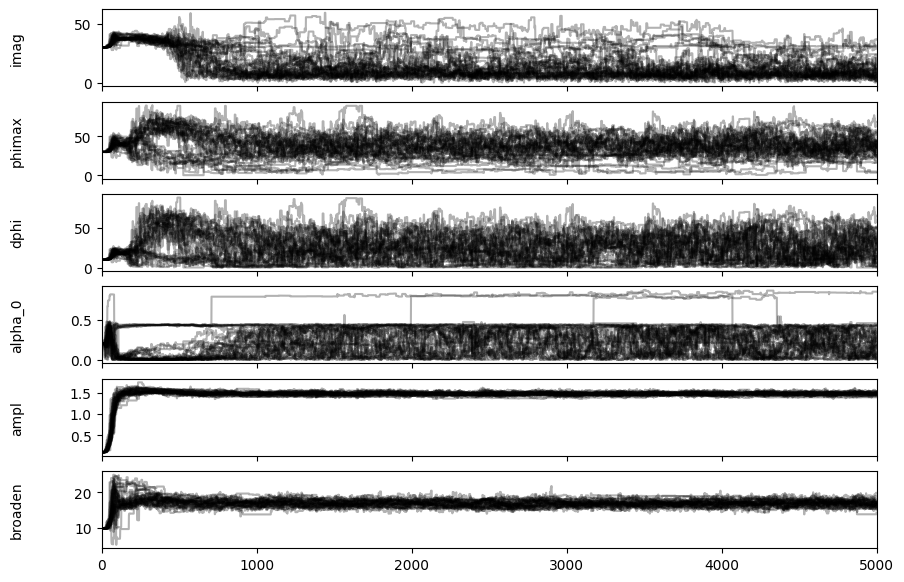

In [28]:
# plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["imag", "phimax", "dphi", "alpha_0", "ampl", "broaden"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

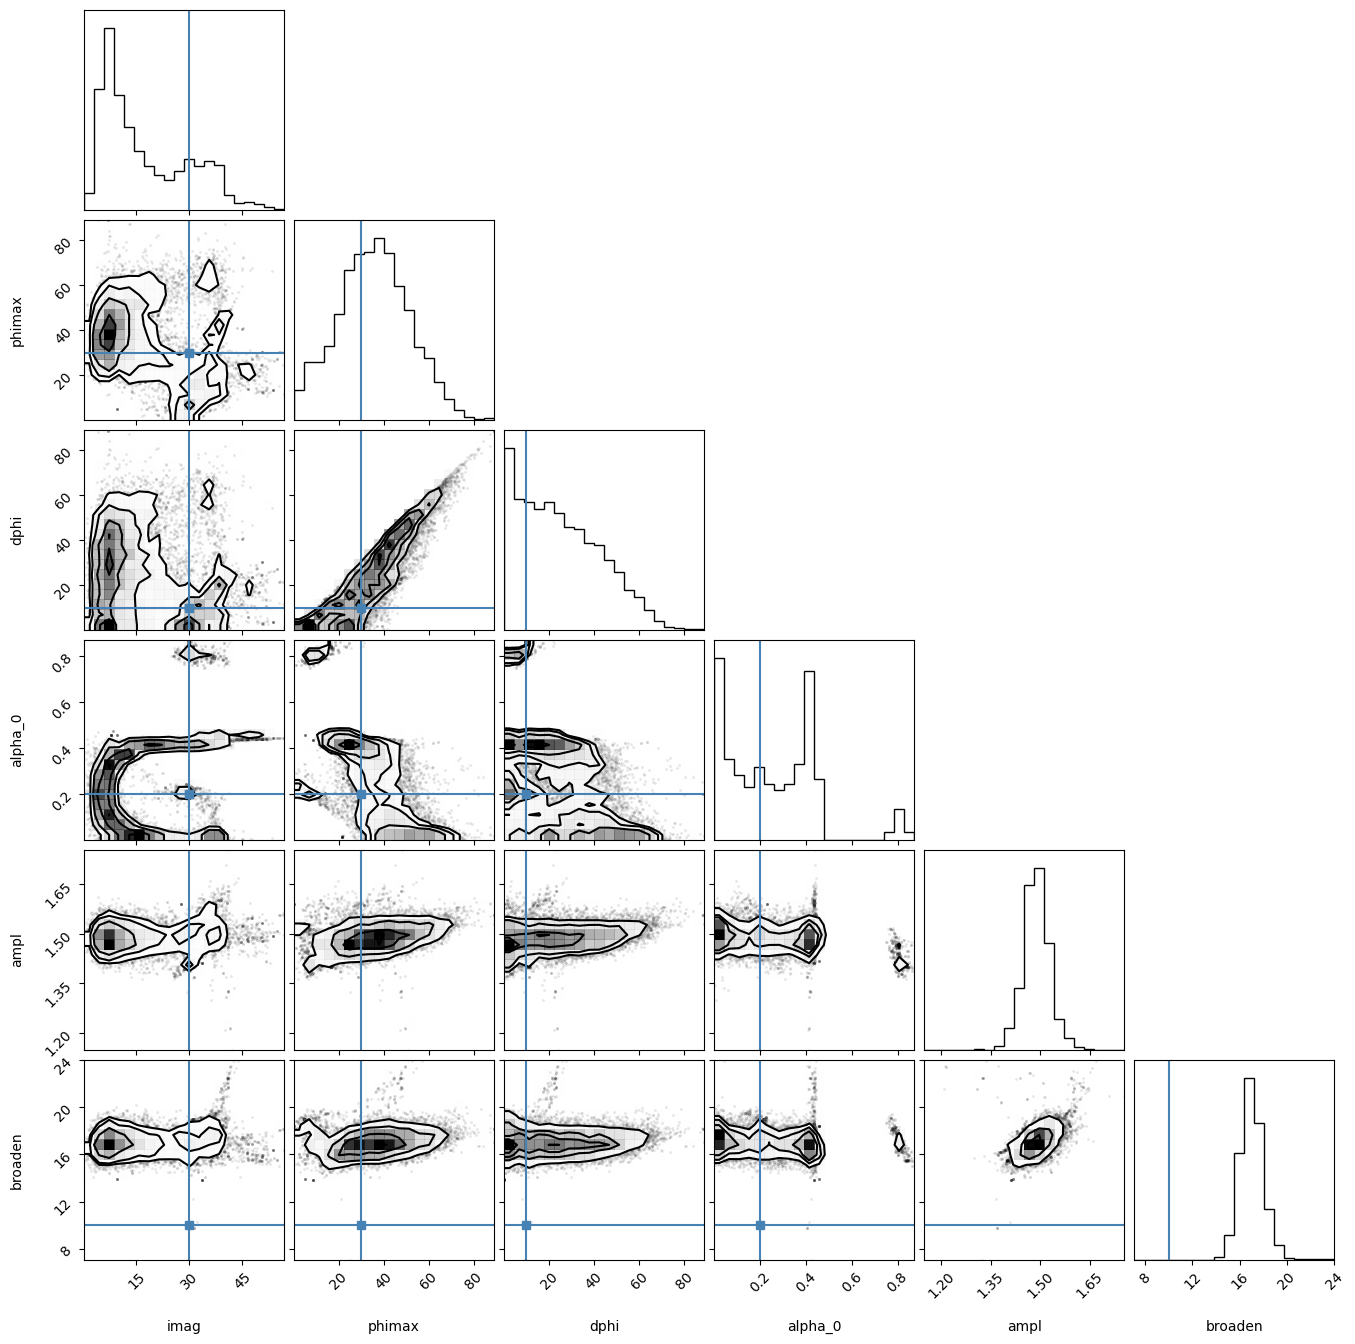

In [29]:
# corner plot
labels = ["imag", "phimax", "dphi", "alpha_0", "ampl", "broaden"]
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=initial
)

(0.4, 0.5], 12.84, 35.68, 23.12, 0.24, 1.49, 16.99


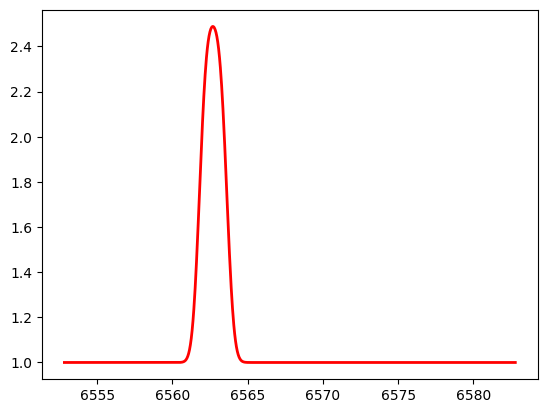

In [32]:
# plot best fit
imag, phimax, dphi, alpha_0, ampl, broaden = np.median(flat_samples, axis=0)

m = model(vbins, imag, phimax, dphi, alpha_0, ampl, broaden)

# plt.errorbar(v_mids, y, yerr=std, fmt='o')
plt.plot(x, m, zorder=100, lw=2, c='r')

# plt.xlim(-100,100)


# round up the values to 2 decimals and print them
imag, phimax, dphi, alpha_0, ampl, broaden = np.round([imag, phimax, dphi, alpha_0, ampl, broaden], 2)
print(f"{index}, {imag}, {phimax}, {dphi}, {alpha_0}, {ampl}, {broaden}")


phase, obliquity, upper limit ring latitude, width ring, start_phase, relative amplitude, broadening[km/s]

(0.2, 0.3], 50.65, 6.58, 3.88, 0.89, 1.09, 20.38

(0.3, 0.4], 26.34, 48.81, 27.4, 0.1, 1.45, 19.74

(0.4, 0.5], 12.84, 35.68, 23.12, 0.24, 1.49, 16.99